In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [4]:
PATH = "C:/Users/User/Downloads/Telegram Desktop"

In [5]:
df = pd.read_csv(PATH + "/all.csv")

In [200]:
file1 = open(PATH + '/NYSE.txt',"r") 
NYSE_stocks = []
NYSE_stockss ={}
for line in file1:
    ln = line.split('\t')
    ln[1] = ln[1].split('\n')[0]
    NYSE_stockss[ln[0]] = ln[1]
    NYSE_stocks.append(ln)
file1.close()

In [7]:
NYSE_stocks = NYSE_stocks[1:-1]

In [8]:
NYSE_indexes = []
for stock in NYSE_stocks:
    index = stock[0]
    NYSE_indexes.append(index)
#print(NYSE_indexes)

In [9]:
def count_daily_profit(day):
    return np.log(day[0] / day[1])

def get_log_profits(prices, columns, ticker):
    prices_ = zip(prices[0:-1], prices[1:])
    prices_ = map(count_daily_profit, prices_)
    res = [ticker]
    res.extend(prices_)
    while(len(res) < len(columns)):
        res.append(res[-1])
#     stock_profits = np.zeros(len(columns))
#     stock_profits.append(ticker)
    return pd.Series(res, index=columns)

In [10]:
log_profits = pd.DataFrame(columns=np.unique(df.date))

In [11]:
log_profits.insert(column = 'ticker', loc = 0, value = 0)

In [12]:
no_data_count = 0
for stock_index in NYSE_indexes:
    stock_data = df.loc[df['ticker'] == stock_index]
#     print(stock_data)
    if stock_data.shape[0] == 0:
        no_data_count = no_data_count + 1
        continue
    stock_profits = get_log_profits(np.array(stock_data['close']), log_profits.columns, stock_index)
#     print(stock_profits.shape)
    # print(stock_profits)
    log_profits = log_profits.append(stock_profits, ignore_index=True)

In [13]:
log_profits = log_profits.set_index('ticker')
log_profits = log_profits.transpose()
log_profits = log_profits.astype(float)

In [202]:
means = log_profits.mean().sort_values(ascending=False)
my_indexes = means.index[:15]
for  v in my_indexes:
    print(NYSE_stockss[v])
prev_indexes=['HI', 'PLOW', 'VBF', 'RVT', 'AMN', 'AGS', 'MFV', 'VNCE', 'CXH', 'UAA', 'HLI', 'SE', 'SDT', 'BIP', 'OXY', 'AGI', 'IGA', 'JWN', 'ANH', 'CABO', 'ARI', 'KDMN', 'OR', 'SB', 'ESTE', 'RLH', 'TEX', 'PCN', 'DLX', 'DVN', 'MCX', 'ECCA', 'PRA', 'NVS', 'PHI', 'CBZ', 'DMO', 'SKT', 'MUI', 'BXC', 'UZA', 'GRA', 'TDW', 'GER', 'DRI', 'APRN', 'GMS', 'APH', 'CNC', 'RELX']

Playags Inc
Blue Apron Holdings Inc
Sailpoint Technologies Holdings Inc
Four Seasons Education [Cayman] Inc
Jianpu Technology Inc
Seacor Marine Holdings Inc
Metropolitan Bank Holding Corp
Sogou Inc
Cannae Holdings Inc
Seadrill Ltd
Sea Limited ADR
Hamilton Beach Brands Holding Company Cl A
Dreyfus Alcentra Global Credit Income 2024 Targe
Vince Holding Corp
AT&T Inc 5.350% Global Notes Due 2066


Лучший набор акций:
['HI', 'PLOW', 'VBF', 'RVT', 'AMN', 'AGS', 'MFV', 'VNCE', 'CXH',
       'UAA', 'HLI', 'SE', 'SDT', 'BIP', 'OXY', 'AGI', 'IGA', 'JWN',
       'ANH', 'CABO', 'ARI', 'KDMN', 'OR', 'SB', 'ESTE', 'RLH', 'TEX',
       'PCN', 'DLX', 'DVN', 'MCX', 'ECCA', 'PRA', 'NVS', 'PHI', 'CBZ',
       'DMO', 'SKT', 'MUI', 'BXC', 'UZA', 'GRA', 'TDW', 'GER', 'DRI',
       'APRN', 'GMS', 'APH', 'CNC', 'RELX']

In [53]:
my_chosen_log_profits = log_profits[my_indexes]
prev_chosen_log_profits = log_profits[prev_indexes]

In [56]:
my_annual_profits = my_chosen_log_profits.sum(axis=0)
my_cov_matrix = my_chosen_log_profits.cov()

prev_annual_profits = prev_chosen_log_profits.sum(axis=0)
prev_cov_matrix = prev_chosen_log_profits.cov()

In [57]:
from scipy.special import softmax

In [190]:
def short_allow_weights(arr, size):
    n_samples = len(arr)
    sample_1 = np.random.uniform(0, 1, int(n_samples/3))
    sample_2 = sample_1 * (-1)
    sample_3 = np.random.uniform(0, 1, int(n_samples / 3))
    sample_3 /= np.sum(sample_3)
    sample = np.concatenate((sample_1, sample_2, sample_3))
    while(len(sample) < n_samples):
        sample = np.append(sample, 0)
    np.random.shuffle(sample)
#     print(sample)
    return [sample]

In [204]:
def get_portfel(chosen_log_profits, cov_matrix, annual_profits, weights_function):
    num_ports = 10000
    n_stocks = chosen_log_profits.shape[1]
    all_weights = np.zeros((num_ports, n_stocks))
    ret_arr = np.zeros(num_ports)
    vol_arr = np.zeros(num_ports)
    sharpe_arr = np.zeros(num_ports)

    counter = 0
    for x in range(num_ports):
        # Weights in [-1; 1]
        weights = weights_function(np.ones(n_stocks)*1000.,size=1)[0]
#         print(weights)
    #     weight = np.ones(50) * 0.02
    #     weights =  weights * 2 - 1

        # Save weights
        all_weights[x,:] = weights

        # Expected return
        ret_arr[x] = np.sum( (annual_profits * weights) )

    #     # Expected volatility
        vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    #     # Sharpe Ratio
        sharpe_arr[x] = ret_arr[x]/vol_arr[x]
        counter = counter + 1
        if ((counter / 100) == 0):
            clear_output()
            print(counter, '/', num_ports)
    return (ret_arr, vol_arr, all_weights)

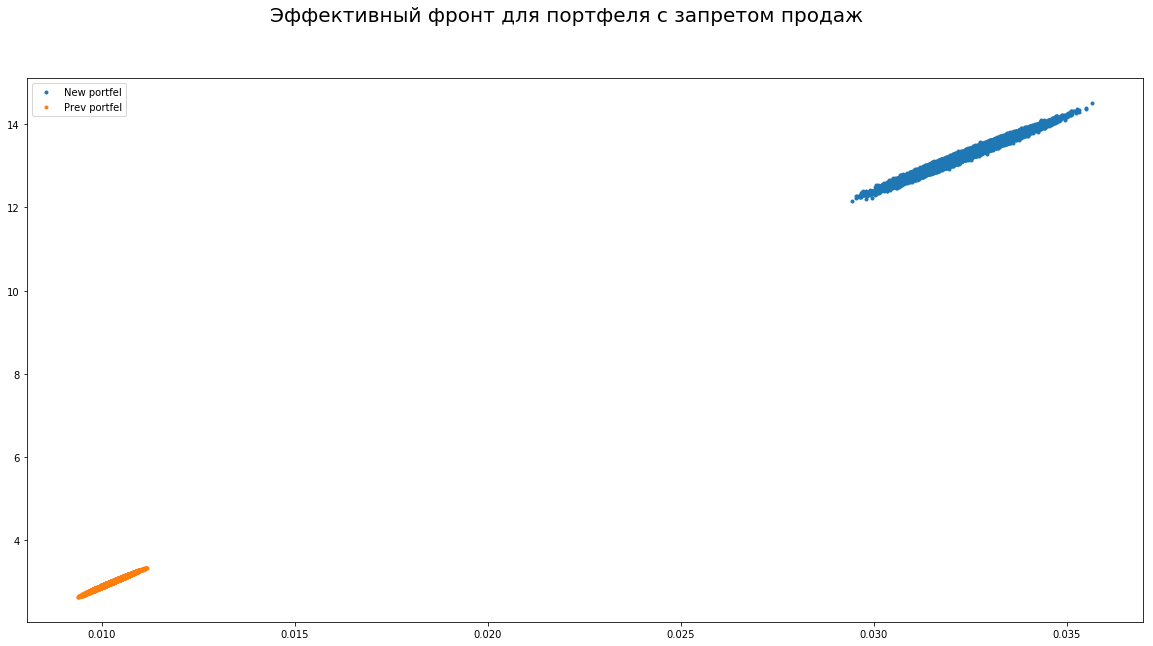

In [196]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Эффективный фронт для портфеля с запретом продаж', fontsize=20)

ret_arr, vol_arr, all_weights = get_portfel(my_chosen_log_profits,my_cov_matrix, my_annual_profits, np.random.dirichlet)
plt.plot(vol_arr, ret_arr, '.', label='New portfel')

ret_arr, vol_arr, all_weights = get_portfel(prev_chosen_log_profits,prev_cov_matrix, prev_annual_profits, np.random.dirichlet)
plt.plot(vol_arr, ret_arr, '.', label='Prev portfel')

plt.legend()
plt.show()

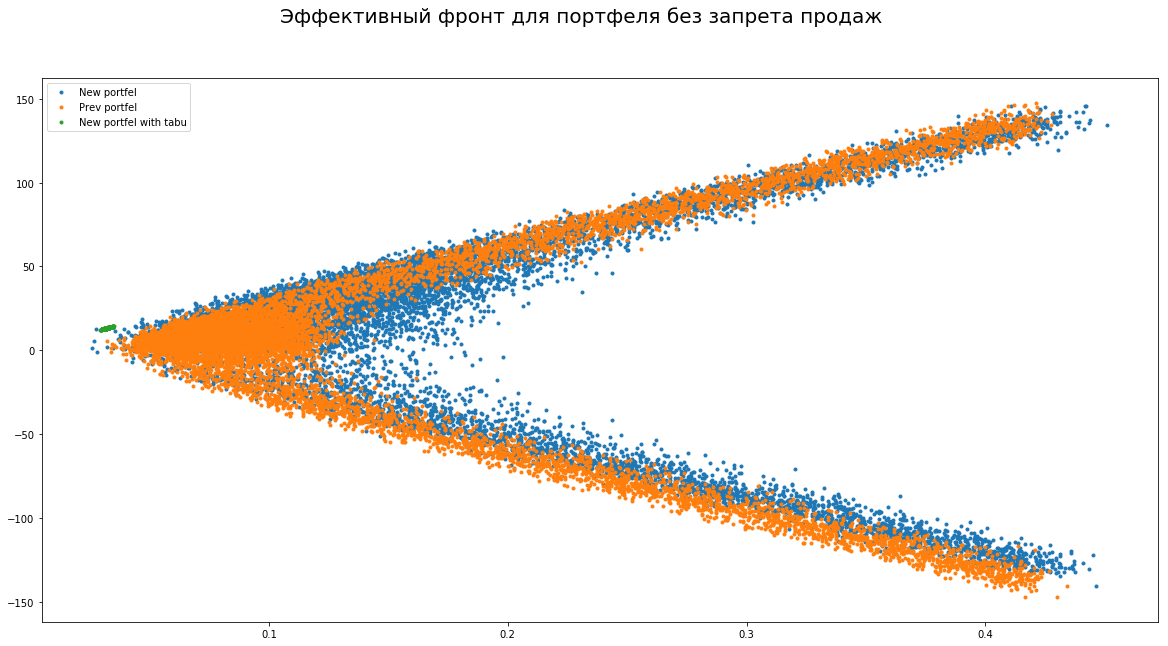

In [206]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Эффективный фронт для портфеля без запрета продаж', fontsize=20)


ret_arr, vol_arr, all_weights = get_portfel(my_chosen_log_profits,my_cov_matrix, my_annual_profits, short_allow_weights)
vol_arr = np.clip(vol_arr, -1, 200)
ret_arr = np.clip(ret_arr, -200, 200)

plt.plot(vol_arr, ret_arr, '.', label='New portfel')

ret_arr, vol_arr, all_weights = get_portfel(prev_chosen_log_profits,prev_cov_matrix, prev_annual_profits, short_allow_weights)
vol_arr = np.clip(vol_arr, -1, 200)
ret_arr = np.clip(ret_arr, -200, 200)

plt.plot(vol_arr, ret_arr, '.', label='Prev portfel')

ret_arr, vol_arr, all_weights = get_portfel(my_chosen_log_profits,my_cov_matrix, my_annual_profits, np.random.dirichlet)

plt.plot(vol_arr, ret_arr, '.', label='New portfel with tabu')

plt.legend()
plt.show()

In [195]:
v = short_allow_weights(np.ones(50)*100000,size=1)
print(v[0])
np.sum(v[0])

[ 0.90789541  0.02357148 -0.65598602  0.          0.06743335  0.08133282
 -0.66825869 -0.75936857  0.0964941  -0.90789541 -0.47140646  0.52347752
 -0.1855106   0.08134455  0.1855106   0.62637638  0.65598602 -0.88835428
  0.34962442  0.25751859 -0.96784987 -0.44760108  0.06455274  0.04645445
  0.08241526  0.88835428  0.          0.96784987 -0.62647704 -0.62637638
 -0.18972094  0.02280128  0.05857059 -0.20438862  0.09985861  0.20438862
  0.18972094 -0.25751859  0.44760108  0.75936857 -0.52347752  0.62647704
  0.47140646  0.66825869 -0.34962442  0.09287255  0.08942872  0.00485047
  0.03152678  0.05649227]


1.0000000000000002